# Data Science 1: ML
## Big Assignment
### Abylaikhan Shaken

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (29733, 61)
Test shape: (9911, 60)


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0,7


## EDA

In [3]:
# Let’s check the distribution of the is_popular variable in our train dataset
target_col = 'is_popular'
train[target_col].value_counts(normalize=True)
# Well, 12% are popular. I think it is good enough to proceed with predictions

is_popular
0    0.878351
1    0.121649
Name: proportion, dtype: float64

In [4]:
# Let's check for Missing Values
# Check missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values in training data:\n", missing)

# Same for test
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
print("Missing values in test data:\n", missing_test)

Missing values in training data:
 Series([], dtype: int64)
Missing values in test data:
 Series([], dtype: int64)


C:\Users\User\AppData\Local\Temp\ipykernel_16224\963509038.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')


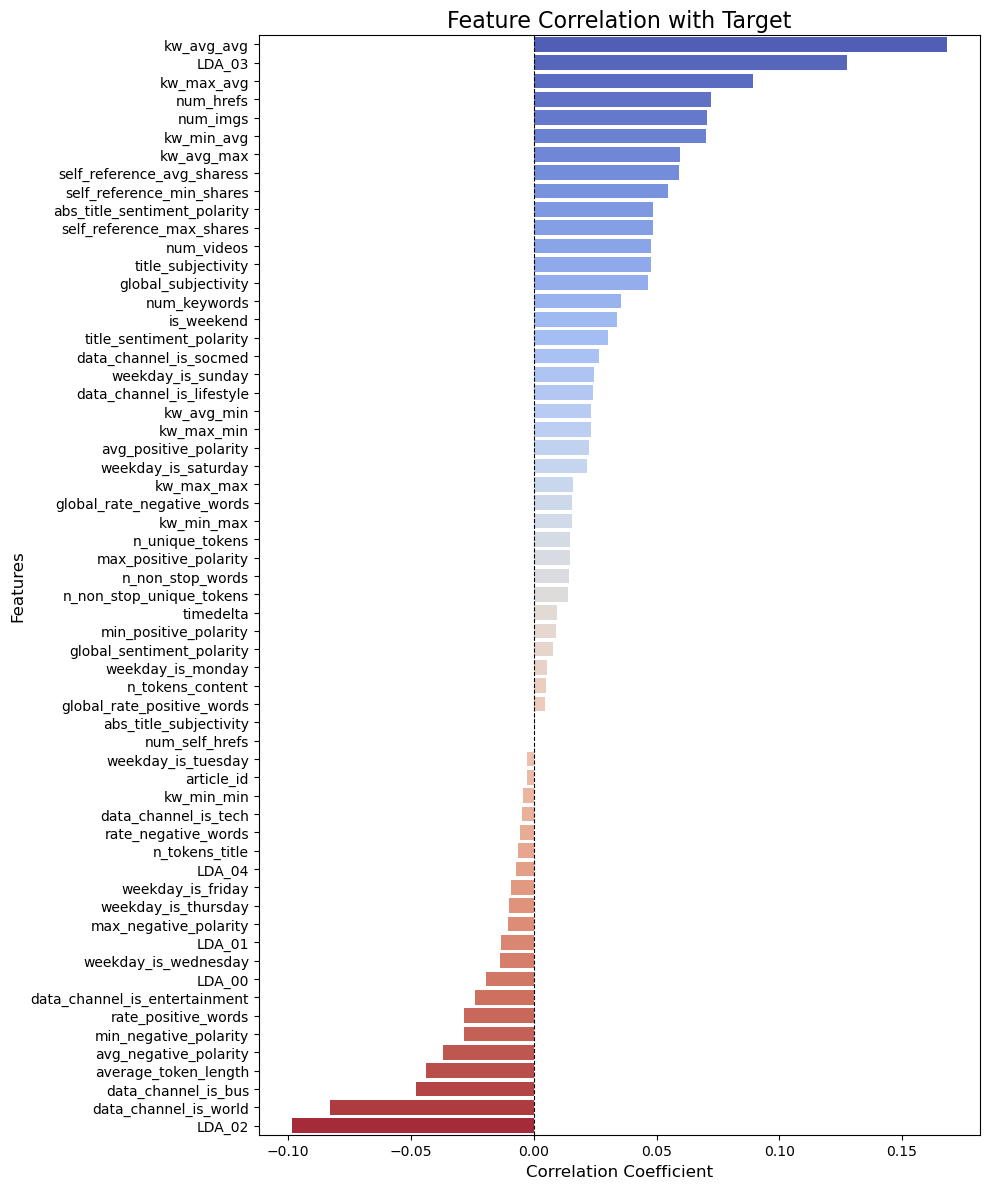

In [6]:
# Calculate correlation with target
corr = train.corr()[target_col].drop(target_col).sort_values(ascending=False)

# Clean up: drop NaN values if any
corr = corr.dropna()

# Plot
plt.figure(figsize=(10, 12))  # Taller for better readability
sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')

# Plot formatting
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.title("Feature Correlation with Target", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### The graph shows that only a few features, such as kw_avg_avg, LDA_03, and kw_max_avg, have a modest positive correlation with the target (is_popular), while most features exhibit very weak or negative relationships, indicating limited linear predictiveness

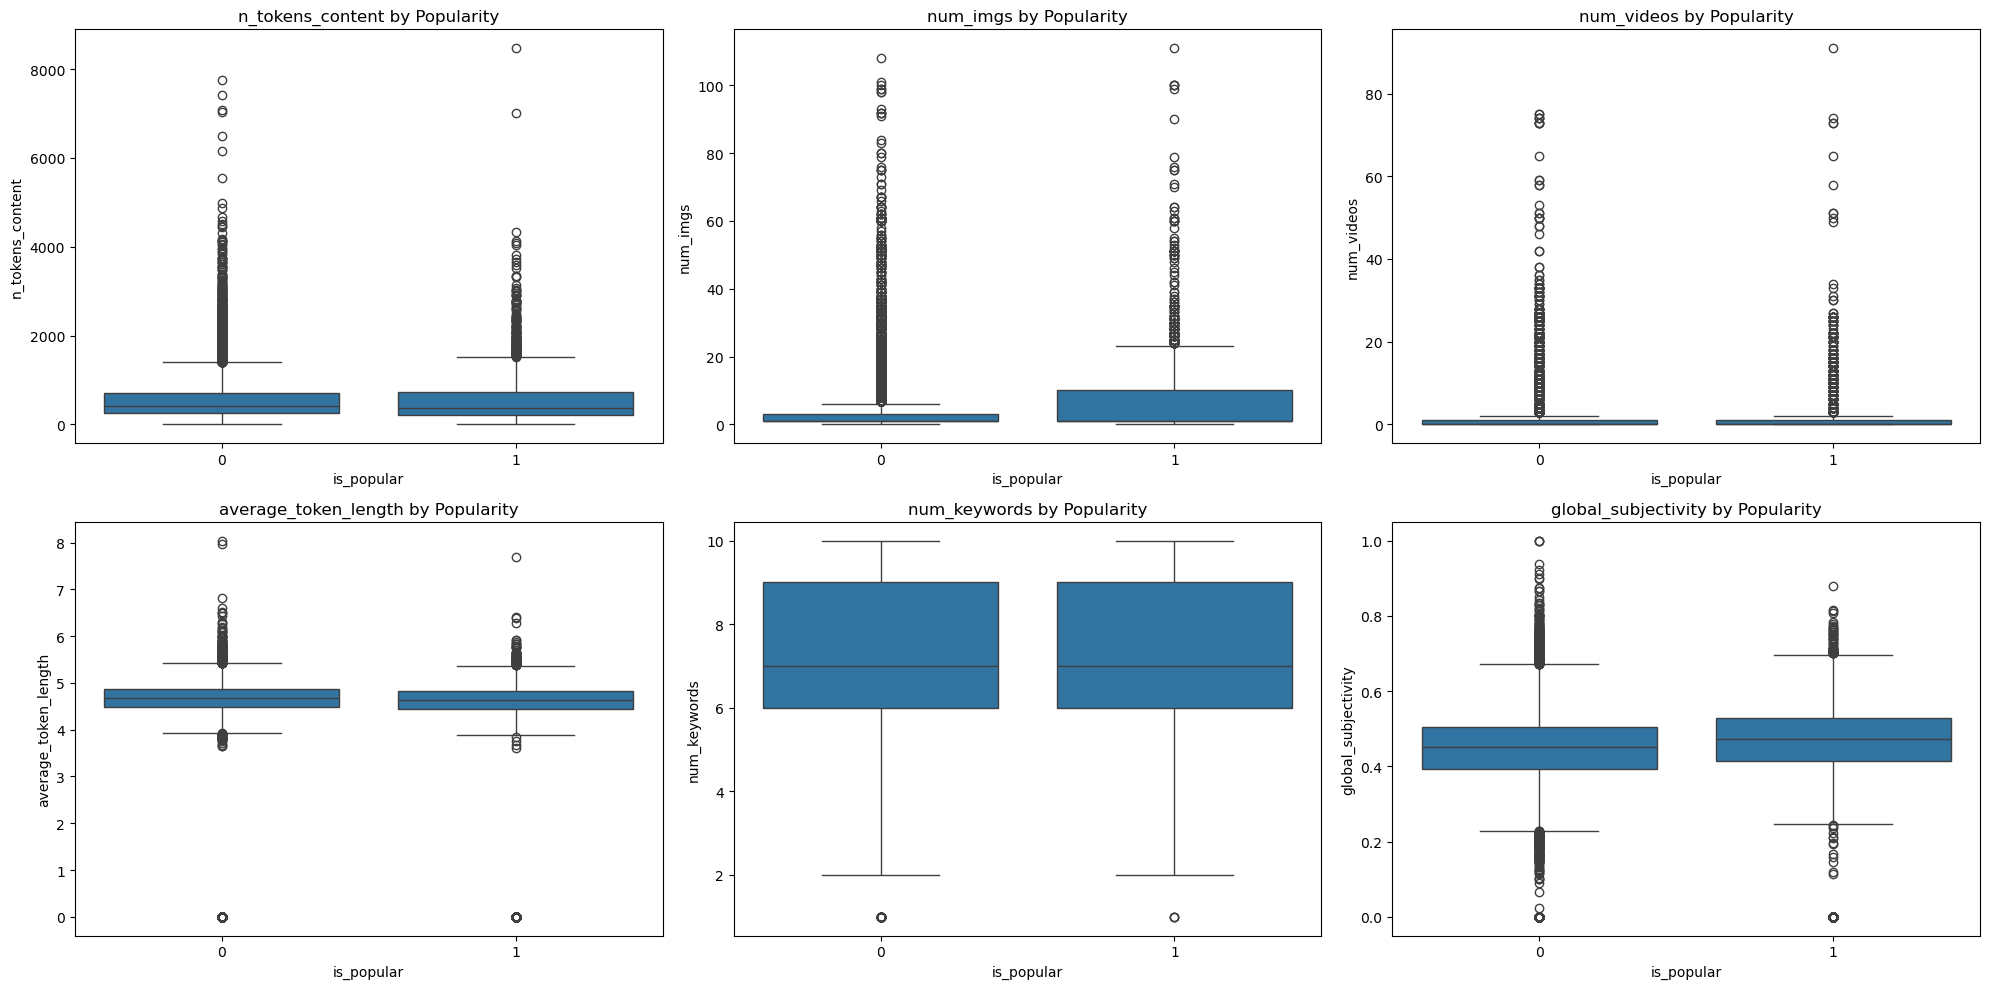

In [51]:
# List of interesting features to explore
feature_list = [
    'n_tokens_content', 'num_imgs', 'num_videos',
    'average_token_length', 'num_keywords',
    'global_subjectivity'
]

# Create 2x4 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(feature_list):
    sns.boxplot(data=train, x='is_popular', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Popularity')

# Remove last empty subplot if feature count < 8
for j in range(len(feature_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### n_tokens_content
Popular articles tend to have slightly more content (longer articles), but the distributions largely overlap. This feature alone may not be a strong discriminator, but it adds value when combined with others.

### num_imgs
There's a clear shift toward higher image counts in popular articles. While the median is similar, popular articles have a wider upper range, suggesting image-rich content may drive popularity.

### num_videos
Similar to images, but with a weaker effect. Most articles have few or no videos. Still, popular ones show slightly more outliers with high video counts.

### average_token_length
Very similar distributions between popular and unpopular. This feature likely holds low predictive power on its own.

### num_keywords
Slight tendency for popular articles to have more keywords, hinting at better SEO or tagging — a subtle but useful feature.

### global_subjectivity
A slight increase in subjectivity for popular articles. This may indicate that more opinionated or emotional writing resonates more with readers.



## Data Cleaning

In [7]:
# Drop columns with the same value in all rows
constant_cols = [col for col in train.columns if train[col].nunique() == 1]
print("Dropping constant columns:", constant_cols)

train.drop(columns=constant_cols, inplace=True)
test.drop(columns=constant_cols, inplace=True)

Dropping constant columns: []


In [8]:
# Checking for Duplicates
print("Duplicates in training set:", train.duplicated().sum())
train.drop_duplicates(inplace=True)

Duplicates in training set: 0


In [9]:
print(train.columns.tolist())

['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_pos

In [11]:
# Copy original features (without article_id or target)
X_base = train.drop(columns=['article_id', 'is_popular'])
y_base = train['is_popular']
X_test_base = test.drop(columns=['article_id'])

## Feature Engineering
I know that this part was not mentioned in instructions, and in fact might as well overfit my model, however I wanted to improve AUC results

In [30]:
X_base['non_stop_ratio'] = train['n_non_stop_unique_tokens'] / (train['n_non_stop_words'] + 1)
X_test_base['non_stop_ratio'] = test['n_non_stop_unique_tokens'] / (test['n_non_stop_words'] + 1)
# Measures how diverse the vocabulary is, ignoring stopwords. Could signal article complexity or quality

In [31]:
X_base['img_per_token'] = train['num_imgs'] / (train['n_tokens_content'] + 1)
X_test_base['img_per_token'] = test['num_imgs'] / (test['n_tokens_content'] + 1)

X_base['video_per_token'] = train['num_videos'] / (train['n_tokens_content'] + 1)
X_test_base['video_per_token'] = test['num_videos'] / (test['n_tokens_content'] + 1)
# Visual content might boost popularity — these features reflect how visual-heavy an article is

In [32]:
X_base['sentiment_product'] = train['global_subjectivity'] * train['global_sentiment_polarity']
X_test_base['sentiment_product'] = test['global_subjectivity'] * test['global_sentiment_polarity']
# Combines how opinionated and emotional the article is. Strong opinions may boost shares

In [33]:
X_base['pos_neg_ratio'] = train['global_rate_positive_words'] / (train['global_rate_negative_words'] + 1e-5)
X_test_base['pos_neg_ratio'] = test['global_rate_positive_words'] / (test['global_rate_negative_words'] + 1e-5)
# Overall tone of the article: more positive than negative? Could influence sharing

In [34]:
X_base['log_tokens'] = np.log1p(train['n_tokens_content'])
X_test_base['log_tokens'] = np.log1p(test['n_tokens_content'])
# Helps reduce outlier impact from articles with very high word count

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_base, y_base, test_size=0.2, stratify=y_base, random_state=42)

## Model selection and parameter tuning

### Random Forest

In [16]:
# Train basic RF model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict probabilities for AUC (only need positive class prob)
val_preds = rf.predict_proba(X_val)[:, 1]

# Evaluate
auc = roc_auc_score(y_val, val_preds)
print(f"Validation AUC (baseline RF): {auc:.4f}")
# I need to get at least 0.72, so I need to find a better model

Validation AUC (baseline RF): 0.6804


### Parameter Tuning – GridSearchCV - RF

In [26]:
# I did lots of trials in this parameter tuning; below are ones I think that are reasonable to check
pparam_grid = {
    'n_estimators': [300, 500, 700],               # More trees
    'max_depth': [8, 10, 12, None],                # Deeper trees
    'min_samples_split': [2, 3, 5],                # Smaller splits
    'min_samples_leaf': [1, 2],                    # Smaller leaves
    'max_features': ['sqrt', 'log2', 0.3, 0.5],    # Some custom values
    'bootstrap': [True, False]
}

In [27]:
# We will be looking for the best parameters for RF
rf = RandomForestClassifier(random_state=42)

# Run randomized search with 25 sampled combinations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=25,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Evaluate best model
best_rf = random_search.best_estimator_
val_preds = best_rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_preds)

print(f"Random Search RF AUC: {auc:.4f}")
print("Best Parameters:", random_search.best_params_)

# 0.7 is below what I was looking for, thus, I'll be looking for another model

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Random Search RF AUC: 0.7006
Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 8, 'bootstrap': True}


### XGBoost

In [40]:
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_preds)
print(f"XGBoost AUC: {xgb_auc:.4f}")

XGBoost AUC: 0.7147


### Parameter Tuning – GridSearchCV - XG

In [43]:
param_grid = {
    'n_estimators': [1000, 3000, 5000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}

In [45]:
# Define model
xgb = XGBClassifier(eval_metric='auc', random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=25,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Evaluate
best_xgb = random_search.best_estimator_
val_preds = best_xgb.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_preds)

print(f"Random Search XGBoost AUC: {auc:.4f}")
print("Best Parameters:", random_search.best_params_)

C:\Users\User\anaconda3\envs\disaster-nlp\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=25. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Search XGBoost AUC: 0.7147
Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


Interestingly enough I got same parameters from GridSearch to those initial parameters of XGBoost. XGBoost turned out to be the best model because it could handle complex patterns in the data better than the others. 
Unlike Logistic Regression, which is linear, XGBoost can capture nonlinear relationships and interactions between features. It also includes regularization, which helps prevent overfitting, 
and doesn’t require feature scaling like some other models. After trying different models and tuning their parameters, 
XGBoost gave the highest validation AUC score of 0.7147, showing it was the most effective at predicting which articles would become popular.










## Final Training and Submission File

In [46]:
# Merge full training data
X_full = X_base
y_full = y_base

# Train XGBoost on all data
xgb_final = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_final.fit(X_full, y_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
# Predict probabilities on test data
test_preds = xgb_final.predict_proba(X_test_base)[:, 1]

In [39]:
# Use saved article_id column
submission = pd.DataFrame({
    'article_id': test['article_id'],
    'score': test_preds
})

# Export to CSV
submission.to_csv('xgb_submission.csv', index=False)